# OrthoSAM examples - using an image from SediNet


## Install OrthoSAM

You will need to activate the GPU environment within Google CoLab. Go to `Edit->Notebook settings` and chose the Hardware Settings `T4 GPU` (or any other GPUs if you have purchased additional computing resources). This will restart your kernel/notebook (but you only will need to do this once).

We are using the github repository and install all requirements from `OrthoSAM/requirements_colab.txt`. **Note that this will take a few minutes, because several NVIDIA CUDA libraries and extensions will have to be installed.**

In [1]:
!git clone https://github.com/UP-RS-ESP/OrthoSAM.git

Cloning into 'OrthoSAM'...
remote: Enumerating objects: 2022, done.
remote: Total 2022 (delta 0), reused 0 (delta 0), pack-reused 2022 (from 1)
Receiving objects: 100% (2022/2022), 544.89 MiB | 27.92 MiB/s, done.
Resolving deltas: 100% (626/626), done.


In [3]:
!pip install -r OrthoSAM/requirements_colab.txt

  Cloning https://github.com/openai/CLIP.git (to revision dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1) to /tmp/pip-install-doc1oim9/clip_c844b13713a5471d8fe6921cfd092202
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-doc1oim9/clip_c844b13713a5471d8fe6921cfd092202
  Running command git rev-parse -q --verify 'sha^dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1'
  Running command git fetch -q https://github.com/openai/CLIP.git dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git (to revision dca509fe793f601edb92606367a655c15ac00fdf) to /tmp/pip-install-doc1oim9/segment-anything_56ab1e01fb5d4bd197c6676dee05fee4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-install-doc1oim9/segm

**Next, install the SAM snapshot. We are only installing the high-resolution version.**

In [4]:
!mkdir /content/OrthoSAM/MetaSAM
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!mv sam_vit_h_4b8939.pth /content/OrthoSAM/MetaSAM


--2025-08-19 12:15:32--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 216.137.39.65, 216.137.39.125, 216.137.39.17, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|216.137.39.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   114MB/s    in 12s     

2025-08-19 12:15:44 (200 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



**Update the config to point to the correct directories and paths.**

In [5]:
cd /content/OrthoSAM

/content/OrthoSAM


In [6]:
!python update_config.py

Config updated with base: /content/OrthoSAM


Change directory to `OrthoSAM/code` and import the code base.*italicized text*

# Download an example image from SediNet

In [7]:
!mkdir -p /content/OrthoSAM/data/SediNet
# https://github.com/DigitalGrainSize/SediNet/blob/master/images/5_6.JPG
# !mv 5_6.JPG /content/OrthoSAM/data/SediNet

# Running OrthoSAM

In [8]:
cd /content/OrthoSAM/code

/content/OrthoSAM/code


In [9]:
import json
import os
import sys
from utility import load_config,create_dir_ifnotexist, prompt_fid,load_image, plot_tiling_with_overlap

We have downloaded one image into `/content/OrthoSAM/data/SediNet` and will use this image as a segmentation example. If you have multiple images in that directory, you can process all of them in one run. The image to be processed is controlled by the `id` parameter. Here, we set it to `id=0` to only use the first image.

If you set `id=None`, all files in the directory listed in 'DatasetName' will be processed.

In [20]:
id=0 # Filename or the index after sorting by file name. If not known input None and all files will be listed with the index.
# For this example, we only work with the first image (id=0).

#main_para defines the parameters for the first layer
#it also serves as a template for the later layers.
main_para={'OutDIR': f'SediNet/Sedinet_{id}_up2_org',# where output will be stored relative to the MainOutDIR stored in config.json
    'DatasetName': 'SediNet',#where image is stored
    'fid': id, #Filename or the index after sorting by file name. If index is not known use None and all files will be listed with the index.
    'resolution(mm)': 1, #image resolution in mm/pixel
    'tile_size': 1024,
    'tile_overlap':200,
    'resample_factor': 1, #'Auto': auto select resample rate.
    'input_point_per_axis': 30,
    'dilation_size':5,
    'stability_t':0.85,
    'expected_min_size(sqmm)': 50,
    'min_radius': 0,
    'Calculate_stats': True, # True: calculate statistics.
    'Discord_notification': False,# True: send discord when finished. If you wish to use this feature, please create a file name DWH.txt in the code directory and set the webhook.
    'Plotting': True# True: plot the results
    }

#para_list defines the parameters for the later layers
#each dictionary corresponds to one layer.
# The first layer is defined in main_para.
#the second layer is defined in para_list[0] and so on.
#main_para serves as a template for the later layers.
#and in para_list specify the parameters for each layer that need to be updated.
# para_list = []
para_list=[
    {'resample_factor':1/2,
    }
    ]

#parameters for preprocessing. Only create this list if you want to use preprocessing.
#preprocessing is optional.
pre_para_list=[{#'Gaussian': {'kernel size':3},
                #'CLAHE':{'clip limit':2},
                #'Resample': {'fxy':4},
                #'Buffering': {'crop size': crop_size}
            },{},{}]

You can verify the parameters by looking at the dictonaries

In [21]:
main_para

{'OutDIR': 'SediNet/Sedinet_0_up2_org',
 'DatasetName': 'SediNet',
 'fid': 0,
 'resolution(mm)': 1,
 'tile_size': 1024,
 'tile_overlap': 200,
 'resample_factor': 1,
 'input_point_per_axis': 30,
 'dilation_size': 5,
 'stability_t': 0.85,
 'expected_min_size(sqmm)': 50,
 'min_radius': 0,
 'Calculate_stats': True,
 'Discord_notification': False,
 'Plotting': True}

In [22]:
main_para['1st_resample_factor'] = main_para['resample_factor']
config = load_config()
main_para={**config,**main_para}
main_para['OutDIR'] = os.path.join(main_para.get('MainOutDIR'), main_para.get('OutDIR'))
if not os.path.exists(os.path.join(main_para.get('DataDIR'), main_para.get('DatasetName'))):
    print('Input directory does not exist. Exiting script.')
    sys.exit()

OutDIR=main_para.get('OutDIR')
create_dir_ifnotexist(OutDIR)

/content/OrthoSAM/data/SediNet/5_6.JPG imported


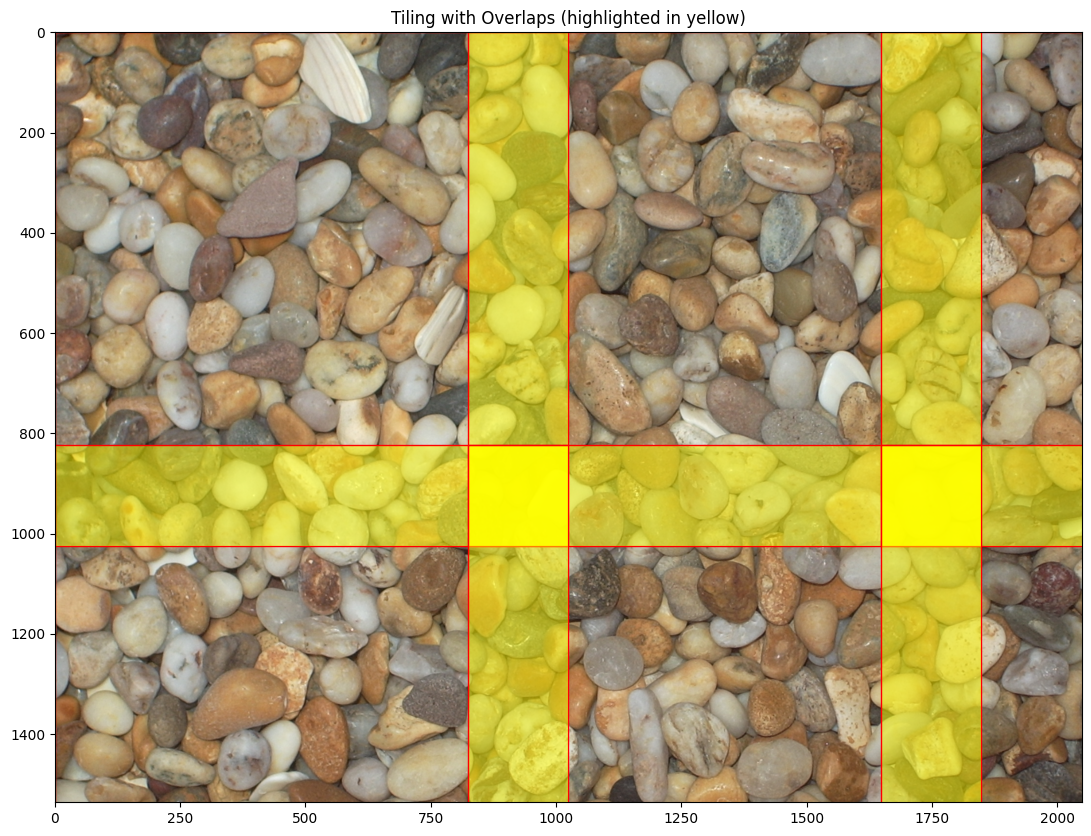

In [23]:
import matplotlib.pyplot as plt
DataDIR = main_para.get('DataDIR')
DSname = main_para.get('DatasetName')
fid = main_para.get('fid')
crop_size = main_para.get('tile_size')
overlap = main_para.get('tile_overlap')
image=load_image(DataDIR,DSname,fid)

plt.figure(figsize=(15,10))
plot_tiling_with_overlap(image, (crop_size,crop_size), overlap)

In [14]:
# Save init_para to a JSON file
para_list.insert(0, {})
pass_para_list = [dict(main_para, **para) for para in para_list]
with open(OutDIR+f'init_para.json', 'w') as json_file:
    json.dump(pass_para_list, json_file, indent=4)
with open(OutDIR+f'pre_para.json', 'w') as json_file:
    json.dump(pre_para_list, json_file, indent=4)

In [15]:
from OrthoSAM import orthosam
orthosam(pass_para_list)

Output hidden; open in https://colab.research.google.com to view.

# Verify results and plot

Here we do some first-oder analysis of the output statistic data.

In [24]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

merged_results = pd.read_csv('/content/OrthoSAM/output/SediNet/Sedinet_0_up2_org/props.csv')

In [25]:
merged_results.head()

,label,centroid-0,centroid-1,axis_major_length,axis_minor_length,area,perimeter,IR,h,IRt,IRn,mean_R,mean_G,mean_B,median_R,median_G,median_B
0,1,51.447151,442.729894,110.446314,101.913859,8704.0,355.220346,0.866828,0.001614,0.997580,0.868931,182.592486,144.814453,96.842371,184.0,137.0,87.0
1,2,35.941292,1807.150685,51.654952,27.867122,1022.0,146.024387,0.602296,0.089482,0.870890,0.691587,113.761252,100.433464,80.425636,116.0,103.5,84.0
2,3,84.988431,169.490051,117.171667,94.528627,8644.0,355.303607,0.860450,0.011440,0.982926,0.875396,150.280773,134.250810,106.088385,153.0,136.0,106.0
3,4,56.149029,626.274890,51.854418,49.120602,1597.0,188.610173,0.564137,0.000733,0.998901,0.564758,163.501565,165.520351,144.077019,169.0,174.0,153.0
4,5,62.279221,1766.721320,71.525998,38.786690,1848.0,202.551299,0.566033,0.088082,0.872833,0.648501,91.094156,77.805736,59.996212,91.0,78.0,59.0


In [26]:
len(merged_results)

493

In [27]:
merged_results.describe()

,label,centroid-0,centroid-1,axis_major_length,axis_minor_length,area,perimeter,IR,h,IRt,IRn,mean_R,mean_G,mean_B,median_R,median_G,median_B
count,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000
mean,247.000000,801.292400,1022.158766,98.558410,60.065366,5246.707911,279.330939,0.673057,0.081171,0.886334,0.755176,144.324331,127.462008,103.609493,146.836714,129.390467,104.803245
std,142.461106,416.747496,579.240778,45.754472,31.394722,4305.403162,127.412711,0.145537,0.081336,0.107831,0.114269,31.483090,31.259743,30.086007,32.875245,32.586255,31.256330
min,1.000000,35.941292,38.699411,13.902038,8.220486,92.000000,38.627417,0.243048,0.000339,0.479977,0.395999,48.315217,36.858696,25.260870,47.000000,35.500000,24.000000
25%,124.000000,455.643709,518.969253,56.981121,29.942696,1179.000000,159.681241,0.578071,0.022263,0.830467,0.677649,121.018375,105.920455,81.885766,123.000000,107.000000,83.000000
50%,247.000000,808.858297,1014.716278,106.750728,59.315709,4727.000000,302.793939,0.678742,0.051695,0.924184,0.770716,148.621510,126.847951,100.655617,151.000000,128.000000,102.000000
75%,370.000000,1156.292469,1534.036765,129.518052,87.203085,8556.000000,377.362482,0.792042,0.118996,0.966929,0.854297,167.583006,148.670613,123.212381,172.000000,152.000000,125.000000
max,493.000000,1507.101668,2026.227397,246.792420,123.650890,21139.000000,607.553391,0.941572,0.412698,0.999491,0.988566,208.902150,211.749587,201.467844,212.000000,215.000000,204.000000


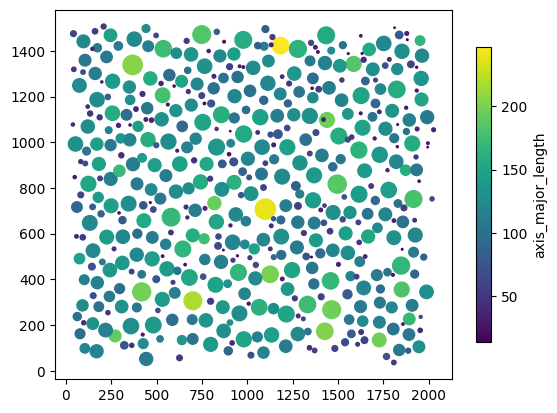

In [28]:
plt.scatter(merged_results['centroid-1'],
            merged_results['centroid-0'],
            c=merged_results['axis_major_length'],
            s=merged_results['area']/100,
            cmap='viridis')
h = plt.colorbar(shrink=0.8)
h.set_label('axis_major_length')

## Loading labeled images

In [29]:
merged_img = np.load('/content/OrthoSAM/output/SediNet/Sedinet_0_up2_org/Merged/Merged_Layers_001.npy')

In [30]:
merged_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [31]:
#convert to float and then set background to nan
merged_img = merged_img.astype(np.float32)

In [32]:
merged_img[merged_img == 0.0] = np.nan

In [33]:
len(np.unique(merged_img[~np.isnan(merged_img)]))

494

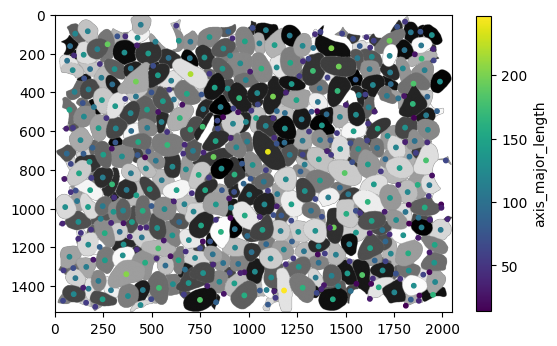

In [34]:
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gray(vals))
plt.imshow(merged_img, cmap=cmap)

plt.scatter(merged_results['centroid-1'], merged_results['centroid-0'], c=merged_results['axis_major_length'], s=10, cmap='viridis')
h = plt.colorbar(shrink=0.8)
h.set_label('axis_major_length')

## Filter out pebbles with a roundness metric (isoperimetric ratio)

There are different ways to remove objects from the database that are no pebbles. You can do this manually by looking at the labelled images (see next point) - but this will be tidious when there are many pebbles. In this example, we rely on a roundness factor (see relevant publications cited in the main manuscript, including Cox, 1927; Pokhrel et al., 2024; Roussillon et al., 2009. The isoperimetric ratio is defined as the ratio of the area in 2D to its perimeter. This metric is dependent on the shape of the pebble, and hence a normalized isoperimetric ratio (IRn) has been developed that removes (partly) a shape dependence. The IRn is the isoperimetric ratio divided by a maximum theoretical isoperimetric ratio (IRt).

In our output database, we provide all variants of the  isoperimetric ratio. For example, we can color each centroid by its IRn:

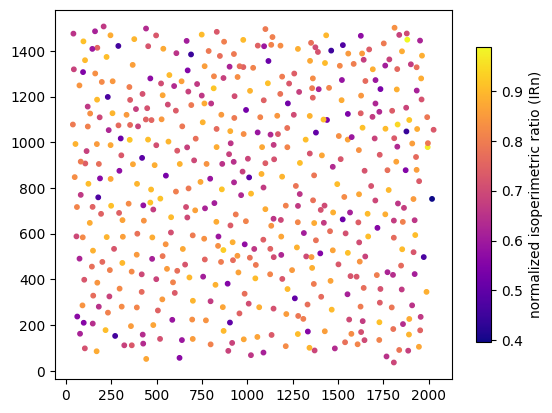

In [35]:
plt.scatter(merged_results['centroid-1'], merged_results['centroid-0'], c=merged_results['IRn'], s=10, cmap='plasma')
h = plt.colorbar(shrink=0.8)
h.set_label('normalized isoperimetric ratio (IRn)')

In [36]:
merged_results[merged_results['IRn'] < 0.49]

,label,centroid-0,centroid-1,axis_major_length,axis_minor_length,area,perimeter,IR,h,IRt,IRn,mean_R,mean_G,mean_B,median_R,median_G,median_B
21,22,152.177194,271.494271,192.098700,78.569585,7156.0,508.315801,0.348027,0.175930,0.755364,0.460741,102.800866,92.892538,90.931666,97.0,86.0,84.0
140,141,497.406337,1971.905503,85.733542,41.072153,1799.0,241.965512,0.386130,0.124047,0.823653,0.468802,153.093385,127.942190,93.314063,157.0,131.0,95.0
233,234,758.957201,178.363409,140.302497,70.495941,5187.0,403.847763,0.399660,0.109662,0.843139,0.474015,163.807403,131.149412,99.302873,167.0,132.0,99.0
235,236,752.130636,2017.573410,63.643313,29.256126,865.0,184.509668,0.319292,0.137015,0.806295,0.395999,102.338728,87.972254,69.465896,108.0,96.0,77.0
334,335,1047.485448,1876.421746,102.911663,32.953979,1821.0,282.716775,0.286297,0.265126,0.644925,0.443923,96.173531,80.663372,66.244920,98.0,83.0,68.0
384,385,1198.523410,231.002795,85.025107,35.256905,1431.0,224.350288,0.357270,0.171200,0.761464,0.469188,144.264850,145.554857,136.972746,145.0,147.0,137.0
435,436,1384.661398,689.714938,136.129166,110.319928,8984.0,507.286363,0.438706,0.010967,0.983628,0.446008,182.935552,157.794301,115.034506,188.0,162.0,116.0
454,455,1421.794581,289.148466,107.488337,60.997576,3617.0,334.107648,0.407179,0.076139,0.889508,0.457758,158.608792,121.388720,80.756152,164.0,123.0,80.0
460,461,1401.465795,1461.972113,124.449439,42.023390,2295.0,308.936075,0.302173,0.245156,0.668913,0.451737,134.089760,97.470153,66.237037,137.0,100.0,67.0
469,470,1425.485913,1526.282973,98.684434,47.881678,2449.0,279.480231,0.394000,0.120145,0.828914,0.475321,121.018375,95.120457,69.996733,123.0,96.0,70.0


In [37]:
merged_img_IRn045 = np.empty_like(merged_img)
merged_img_IRn045.fill(np.nan)
IRn045_df = merged_results[merged_results['IRn'] < 0.5]

for i in range(len(IRn045_df)):
    merged_img_IRn045[merged_img == IRn045_df.iloc[i]['label']] = IRn045_df.iloc[i]['label']

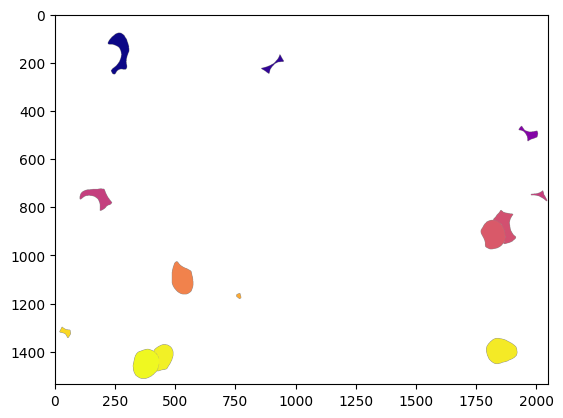

In [38]:
plt.imshow(merged_img_IRn045, cmap='plasma')

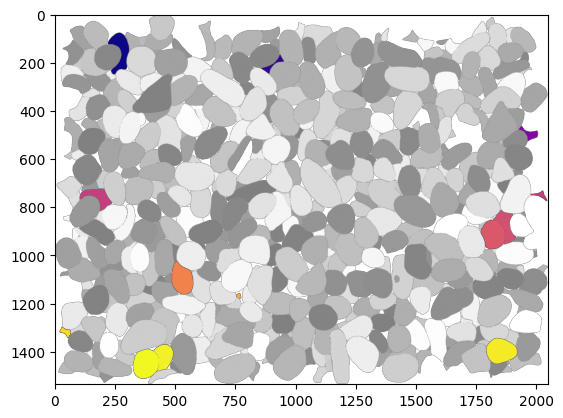

In [39]:
vals = np.linspace(0.5,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gray(vals))
plt.imshow(merged_img, cmap=cmap)

plt.imshow(merged_img_IRn045, cmap='plasma')

## Plot size distribution

In [40]:
IRnabove05_df = merged_results[merged_results['IRn'] >= 0.5]
print(len(IRnabove05_df))
IRnabove05_df.head()

480


,label,centroid-0,centroid-1,axis_major_length,axis_minor_length,area,perimeter,IR,h,IRt,IRn,mean_R,mean_G,mean_B,median_R,median_G,median_B
0,1,51.447151,442.729894,110.446314,101.913859,8704.0,355.220346,0.866828,0.001614,0.997580,0.868931,182.592486,144.814453,96.842371,184.0,137.0,87.0
1,2,35.941292,1807.150685,51.654952,27.867122,1022.0,146.024387,0.602296,0.089482,0.870890,0.691587,113.761252,100.433464,80.425636,116.0,103.5,84.0
2,3,84.988431,169.490051,117.171667,94.528627,8644.0,355.303607,0.860450,0.011440,0.982926,0.875396,150.280773,134.250810,106.088385,153.0,136.0,106.0
3,4,56.149029,626.274890,51.854418,49.120602,1597.0,188.610173,0.564137,0.000733,0.998901,0.564758,163.501565,165.520351,144.077019,169.0,174.0,153.0
4,5,62.279221,1766.721320,71.525998,38.786690,1848.0,202.551299,0.566033,0.088082,0.872833,0.648501,91.094156,77.805736,59.996212,91.0,78.0,59.0


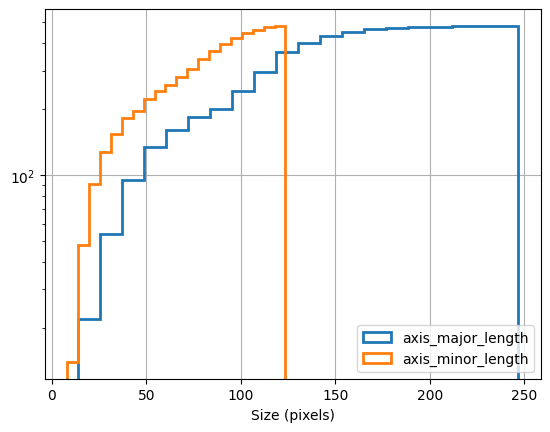

In [41]:
IRnabove05_df.axis_major_length.hist(bins = 20, log = True, cumulative=True, alpha=1, label='axis_major_length', histtype='step', linewidth=2) #density=True
IRnabove05_df.axis_minor_length.hist(bins = 20, log = True, cumulative=True, alpha=1, label='axis_minor_length', histtype='step', linewidth=2) #density=True
plt.xlabel('Size (pixels)')
plt.legend()